In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn import preprocessing

import numpy as np
from numpy.core.numeric import NaN

from joblib import dump, load

from tensorflow import keras
import random
import sklearn
from keras.callbacks import ModelCheckpoint

from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers.legacy import Adam, SGD

import datetime
from keras.callbacks import ModelCheckpoint, EarlyStopping

2024-06-06 10:54:23.353214: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-06 10:54:23.353237: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-06 10:54:23.353822: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-06 10:54:23.357316: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-06 10:54:24.011199: W tensorflow/compiler/tf2

In [33]:
df = pd.read_excel('1-Extrait_Verbatim_Enq_Satisfaction_Patients HC 2023(1-1245)_mai2024.xlsx')
df = df.fillna('')

In [34]:
df

,ID,Verbatim,Eloge / Suggestion d'amélioration / Neutre,Classement thématique,Service d'hospitalisation,Date de réception du questionnaire,Catégories Verbatims,Accesibilité,Personnel,Parcours patient,Qualité des soins,Etablissement,Conditions hôtelières,Autre,Catégories Verbatims Neutre-SA-Eloge,Neutre,Suggestion d'amélioration,Eloge
0,1,De la bienveillance de tout le personnel de to...,Eloge,Personnel - Qualité humaine;Personnel - Remerc...,1ER-Chirurgieconventionnelle,2022-10-13,1,0,1,0,0,0,0,0,2,0,0,1
1,2,"disponibilité du personnel, toujours à l'écoute",Eloge,"Personnel - Disponibilité, réactivité, efficac...",1ER-Chirurgieconventionnelle,2022-10-13,1,0,1,0,0,0,0,0,2,0,0,1
2,3,l'ambiance et la prise en charge sont toujours...,Eloge,Qualité des soins - Prise en charge globale,4EME-HDSSoinsdesupport,2022-10-14,3,0,0,0,1,0,0,0,2,0,0,1
3,4,la qualite du personnel,Eloge,"Personnel - Compétences, sérieux et profession...",1ER-Chirurgieconventionnelle,2022-10-14,1,0,1,0,0,0,0,0,2,0,0,1
4,5,,Eloge,,4EME-HDSOncologiedesemaine,2022-10-14,6,0,0,0,0,0,0,1,2,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,421,Rien du tout,Neutre,,4EME-HDSOncologiedesemaine,2023-09-29,6,0,0,0,0,0,0,1,0,1,0,0
421,422,Pas assez de chambre individuelle,SA,Conditions hôtelières - Chambre (confort / cha...,4EME-HDSOncologiedesemaine,2023-09-29,5,0,0,0,0,0,1,0,1,0,1,0
422,423,L?accessibilité au centre due aux travaux du n...,SA,Accessibilité - Accès handicap / physique,1ER-Chirurgieconventionnelle,2023-09-30,0,0,0,0,0,0,0,0,1,0,1,0
423,424,Rien,Neutre,,4EME-HDSSoinsdesupport,2023-10-01,6,0,0,0,0,0,0,1,0,1,0,0


## Entrainement du modèle Eloge / Insatisfaction

In [5]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.set_visible_devices(physical_devices[1], 'GPU')
tf.config.experimental.set_memory_growth(physical_devices[1], True)

2024-06-03 10:30:54.178476: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-03 10:30:54.178655: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-03 10:30:54.198461: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [35]:
x_train, x_test, y_train, y_test = train_test_split(df['Verbatim'], 
                                                    df["Catégories Verbatims Neutre-SA-Eloge"], 
                                                    test_size=0.3, 
                                                    stratify=df["Catégories Verbatims Neutre-SA-Eloge"], 
                                                    random_state=7)

In [36]:
y_train =np.array(y_train).astype(int)
y_test =np.array(y_test).astype(int)

In [37]:
#pour l'utilisation de softmax:
y_train=keras.utils.to_categorical(y_train, num_classes=3, dtype=y_train.dtype)#'float32'
y_test=keras.utils.to_categorical(y_test, num_classes=3, dtype=y_train.dtype)#'float32'

In [38]:
y_train

array([[0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1],
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1],
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       [1, 0, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [1,

In [11]:
#pip install tensorflow==2.1.0

In [52]:
encoder = hub.load('https://tfhub.dev/google/universal-sentence-encoder/4')

In [13]:
with tf.device('/CPU:0'):
    emb = encoder(['Hello World'])

emb

<tf.Tensor: shape=(1, 512), dtype=float32, numpy=
array([[-2.60742642e-02, -8.46000165e-02, -2.67866217e-02,
         5.67842275e-02,  6.19704723e-02,  3.82260159e-02,
         2.01149341e-02,  2.74087600e-02,  8.69831964e-02,
         3.07917856e-02,  4.10411730e-02,  2.55183429e-02,
         9.65186744e-04,  5.89279719e-02,  4.00954112e-02,
         4.67089340e-02, -3.31279561e-02,  4.07041609e-02,
        -1.19929705e-02, -4.76170555e-02, -8.29668250e-03,
         7.05467463e-02,  4.84353630e-03,  8.09824839e-02,
        -5.70177287e-02, -6.43551499e-02,  6.97147325e-02,
        -6.98838457e-02,  2.64606178e-02, -2.35220529e-02,
         5.52375242e-02,  4.91363965e-02,  5.69897220e-02,
        -6.10719360e-02,  3.60850990e-02,  2.32446156e-02,
         5.60175255e-02, -1.09551996e-02,  4.21308316e-02,
        -1.76953934e-02,  7.12434668e-03,  2.04703063e-02,
        -7.10126385e-02, -8.45577493e-02,  4.36058566e-02,
         4.79397736e-02, -9.01802033e-02, -6.87343776e-02,
      

In [39]:
model = tf.keras.models.Sequential()

model.add(hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4', 
                        input_shape=[], 
                        dtype=tf.string, 
                        trainable=True))

model.add(tf.keras.layers.Dense(2048, activation='relu'))

model.add(tf.keras.layers.Dense(1024, activation='relu'))

model.add(tf.keras.layers.Dense(512, activation='relu'))

model.add(tf.keras.layers.Dense(3, activation='sigmoid'))

model.summary()

model.compile(optimizer=Adam(learning_rate=1e-4), 
              loss='binary_crossentropy', 
              metrics=['AUC'])

earlystop = EarlyStopping(monitor='val_loss', patience=10)
#filepath = "./save_model/modelepochs:{epoch:03d}.hdf5"
#checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min', period=1) #mode was 'auto' #monitor was loss
#path = "./save_logs/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=path,histogram_freq=1)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 512)               256797824 
                                                                 
 dense_8 (Dense)             (None, 2048)              1050624   
                                                                 
 dense_9 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_10 (Dense)            (None, 512)               524800    
                                                                 
 dense_11 (Dense)            (None, 3)                 1539      
                                                                 
Total params: 260472963 (993.63 MB)
Trainable params: 260472963 (993.63 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [40]:
history=model.fit(x_train, y_train, epochs=1000, validation_data=(x_test, y_test), callbacks=[earlystop])

Epoch 1/1000
10/10 [==============================] - 4s 91ms/step - loss: 0.6672 - auc: 0.7657 - val_loss: 0.6241 - val_auc: 0.8824
Epoch 2/1000
10/10 [==============================] - 1s 63ms/step - loss: 0.5826 - auc: 0.8491 - val_loss: 0.5240 - val_auc: 0.8833
Epoch 3/1000
10/10 [==============================] - 1s 63ms/step - loss: 0.4746 - auc: 0.8805 - val_loss: 0.4220 - val_auc: 0.9032
Epoch 4/1000
10/10 [==============================] - 1s 63ms/step - loss: 0.3652 - auc: 0.9273 - val_loss: 0.3169 - val_auc: 0.9583
Epoch 5/1000
10/10 [==============================] - 1s 64ms/step - loss: 0.2563 - auc: 0.9806 - val_loss: 0.2289 - val_auc: 0.9776
Epoch 6/1000
10/10 [==============================] - 1s 64ms/step - loss: 0.1625 - auc: 0.9906 - val_loss: 0.1725 - val_auc: 0.9832
Epoch 7/1000
10/10 [==============================] - 1s 63ms/step - loss: 0.1044 - auc: 0.9952 - val_loss: 0.1505 - val_auc: 0.9840
Epoch 8/1000
10/10 [==============================] - 1s 64ms/step - 

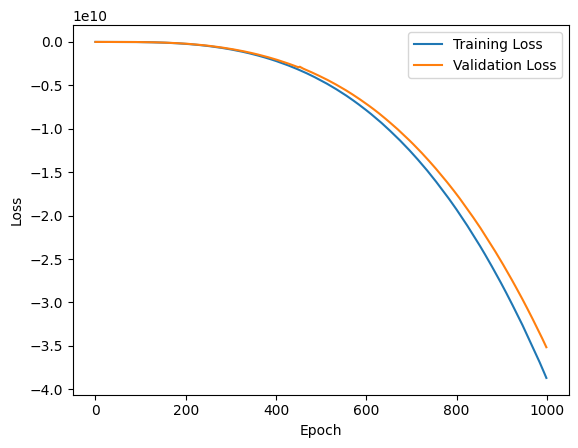

KeyError: 'AUC'

In [30]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [57]:
# Eloge
eloge = model.predict(["Personnels à l'écoute, disponibles et une bonne humeur de l'équipe soignante qui était bien venue pendant cette hospitalisation. Des informations rassurantes données par l'infirmière à ma sortie."])
print("Probabilité : " + str(eloge))
# Pas éloge
peloge = model.predict(["Les repas son vraiment pas terrible. Désolé"])
print("Probabilité : " + str(peloge))
# Neutre
neutre = model.predict(["Rien de particulier."])
print("Probabilité : " + str(neutre))

1/1 [==============================] - 0s 192ms/step
Probabilité : [[7.1438762e-06 1.0237088e-03 9.9963474e-01]]
1/1 [==============================] - 0s 21ms/step
Probabilité : [[6.4414465e-03 9.8958349e-01 7.0249673e-04]]
1/1 [==============================] - 0s 21ms/step
Probabilité : [[9.9891031e-01 4.2426874e-04 1.9480203e-03]]


In [58]:
with tf.device('/CPU:0'):
    loss, accuracy = model.evaluate(x_test, y_test)

4/4 [==============================] - 0s 8ms/step - loss: 0.1572 - auc: 0.9826


In [29]:
Y

array([2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 2, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0,

4/4 [==============================] - 0s 5ms/step - loss: 0.1572 - auc: 0.9826
Mean AUC score: [0.1571996510028839, 0.982635498046875]
4/4 [==============================] - 0s 6ms/step - loss: 0.1572 - auc: 0.9826


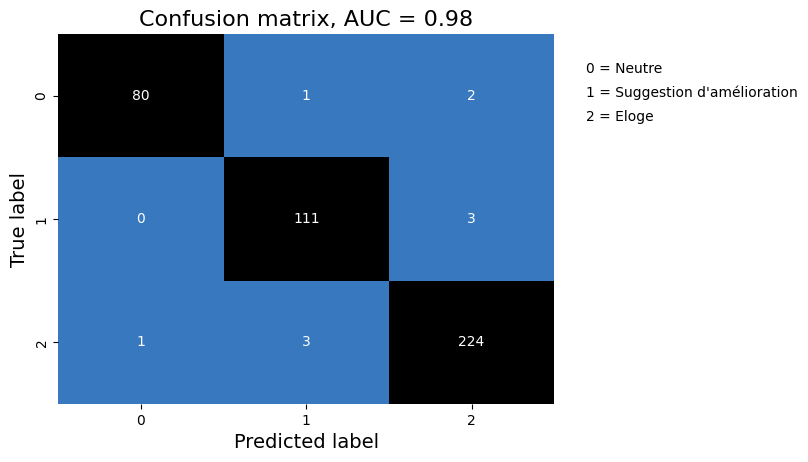

In [77]:
X = np.array(df['Verbatim'])
Y = np.array(df["Catégories Verbatims Neutre-SA-Eloge"])

legend1 = "0 = Neutre"
legend2 = "1 = Suggestion d'amélioration"
legend3 = "2 = Eloge"

#custom_palette = [sns.xkcd_rgb["windows blue"], sns.xkcd_rgb["pale red"], sns.xkcd_rgb["medium green"], "brown", "brown", "teal", "black"] 
custom_palette = [sns.xkcd_rgb["windows blue"], "black", "black","black"] 
sns.set_palette(custom_palette)

results = []
y_preds=model.predict(X)
for elm in y_preds:
    results.append(np.argmax(elm))
y_preds = results
print('Mean AUC score:',model.evaluate(x_test, y_test))
loss, accuracy = model.evaluate(x_test, y_test)
    
ax = sns.heatmap(tf.math.confusion_matrix(labels=Y, predictions=y_preds),annot=True,cbar=False,fmt='d',cmap=custom_palette)
ax.set_ylabel('True label',fontsize=14)
ax.set_xlabel('Predicted label',fontsize=14)
ax.set_title('Confusion matrix, AUC = ' + str(round(accuracy,2)),fontsize=16);
plt.gcf().text(0.95,0.8, legend1)
plt.gcf().text(0.95,0.75, legend2)
plt.gcf().text(0.95,0.7, legend3)

#plt.savefig("Matrice de confusion multiclass verbatims_mai2024", dpi=400, bbox_inches="tight")
plt.show()

In [41]:
TP = 224
TN = 80+111
FP = 5
FN = 1+3
sensitivity = TP/(TP+FN)
specificity = TN/(TN+FP)
print("sensitivity = " + str(sensitivity))
print("specificity = " + str(specificity))

sensitivity = 0.9824561403508771
specificity = 0.9744897959183674


4/4 [==============================] - 0s 5ms/step - loss: 0.1628 - auc: 0.9821
Mean AUC score: [0.1627538502216339, 0.9821014404296875]
4/4 [==============================] - 0s 5ms/step - loss: 0.1628 - auc: 0.9821


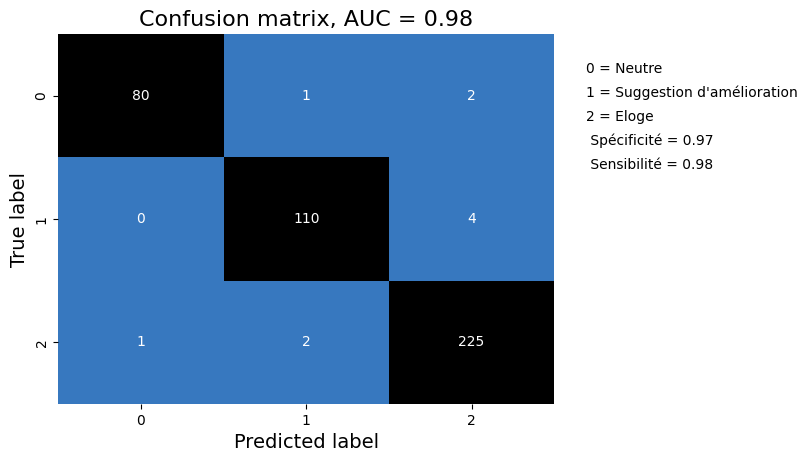

In [42]:
X = np.array(df['Verbatim'])
Y = np.array(df["Catégories Verbatims Neutre-SA-Eloge"])

legend1 = "0 = Neutre"
legend2 = "1 = Suggestion d'amélioration"
legend3 = "2 = Eloge"
legend4 = " Spécificité = " + str(round(specificity,2))
legend5 = " Sensibilité = " + str(round(sensitivity,2))

#custom_palette = [sns.xkcd_rgb["windows blue"], sns.xkcd_rgb["pale red"], sns.xkcd_rgb["medium green"], "brown", "brown", "teal", "black"] 
custom_palette = [sns.xkcd_rgb["windows blue"], "black", "black","black"] 
sns.set_palette(custom_palette)

results = []
y_preds=model.predict(X)
for elm in y_preds:
    results.append(np.argmax(elm))
y_preds = results
print('Mean AUC score:',model.evaluate(x_test, y_test))
loss, accuracy = model.evaluate(x_test, y_test)
    
ax = sns.heatmap(tf.math.confusion_matrix(labels=Y, predictions=y_preds),annot=True,cbar=False,fmt='d',cmap=custom_palette)
ax.set_ylabel('True label',fontsize=14)
ax.set_xlabel('Predicted label',fontsize=14)
ax.set_title('Confusion matrix, AUC = ' + str(round(accuracy,2)),fontsize=16);
plt.gcf().text(0.95,0.8, legend1)
plt.gcf().text(0.95,0.75, legend2)
plt.gcf().text(0.95,0.7, legend3)
plt.gcf().text(0.95,0.65, legend4)
plt.gcf().text(0.95,0.6, legend5)

plt.savefig("Matrice de confusion elogeNeutreSA_mai2024", dpi=400, bbox_inches="tight")
plt.show()

In [44]:
model.save('Best_model_ElogeOrNot_Neutral_03062024.keras')

In [46]:
model = keras.models.load_model('Best_model_ElogeOrNot_Neutral_03062024.keras')

TypeError: The added layer must be an instance of class Layer. Received: layer=KerasLayer of type <class 'str'>.

In [81]:
dump(model, 'Best_model_ElogeOrNot_Neutral_03062024.joblib')

['Best_model_ElogeOrNot_Neutral_03062024.joblib']

In [24]:
model = load('Best_model_ElogeOrNot_Neutral_03062024.joblib')

TypeError: The added layer must be an instance of class Layer. Received: layer=KerasLayer of type <class 'str'>.

## Entrainement du modèle catégorisation des verbatims en multiclass x7

In [84]:
df = pd.read_excel('1-Extrait_Verbatim_Enq_Satisfaction_Patients HC 2023(1-1245)_mai2024.xlsx')
df = df.fillna('')

In [85]:
df

,ID,Verbatim,Eloge / Suggestion d'amélioration / Neutre,Classement thématique,Service d'hospitalisation,Date de réception du questionnaire,Catégories Verbatims,Accesibilité,Personnel,Parcours patient,Qualité des soins,Etablissement,Conditions hôtelières,Autre,Catégories Verbatims Neutre-SA-Eloge,Neutre,Suggestion d'amélioration,Eloge
0,1,De la bienveillance de tout le personnel de to...,Eloge,Personnel - Qualité humaine;Personnel - Remerc...,1ER-Chirurgieconventionnelle,2022-10-13,1,0,1,0,0,0,0,0,2,0,0,1
1,2,"disponibilité du personnel, toujours à l'écoute",Eloge,"Personnel - Disponibilité, réactivité, efficac...",1ER-Chirurgieconventionnelle,2022-10-13,1,0,1,0,0,0,0,0,2,0,0,1
2,3,l'ambiance et la prise en charge sont toujours...,Eloge,Qualité des soins - Prise en charge globale,4EME-HDSSoinsdesupport,2022-10-14,3,0,0,0,1,0,0,0,2,0,0,1
3,4,la qualite du personnel,Eloge,"Personnel - Compétences, sérieux et profession...",1ER-Chirurgieconventionnelle,2022-10-14,1,0,1,0,0,0,0,0,2,0,0,1
4,5,,Eloge,,4EME-HDSOncologiedesemaine,2022-10-14,6,0,0,0,0,0,0,1,2,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,421,Rien du tout,Neutre,,4EME-HDSOncologiedesemaine,2023-09-29,6,0,0,0,0,0,0,1,0,1,0,0
421,422,Pas assez de chambre individuelle,SA,Conditions hôtelières - Chambre (confort / cha...,4EME-HDSOncologiedesemaine,2023-09-29,5,0,0,0,0,0,1,0,1,0,1,0
422,423,L?accessibilité au centre due aux travaux du n...,SA,Accessibilité - Accès handicap / physique,1ER-Chirurgieconventionnelle,2023-09-30,0,0,0,0,0,0,0,0,1,0,1,0
423,424,Rien,Neutre,,4EME-HDSSoinsdesupport,2023-10-01,6,0,0,0,0,0,0,1,0,1,0,0


In [86]:
X_np   = np.array(df['Verbatim'])
Y = np.array(df["Catégories Verbatims"])

In [87]:
x_train, x_test, y_train, y_test = train_test_split(X_np, 
                                                    Y, 
                                                    test_size=0.3, 
                                                    stratify=df["Catégories Verbatims"], 
                                                    random_state=7)

In [88]:
#pour l'utilisation de softmax:
y_train=keras.utils.to_categorical(y_train, num_classes=7, dtype=y_train.dtype)#'float32'
y_test=keras.utils.to_categorical(y_test, num_classes=7, dtype=y_train.dtype)#'float32'

In [89]:
y_train[0:10]

array([[0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0]])

In [90]:
x_train[0:10]

array(["Bonjour Je tien a remercier le personnels les Médecins tous le personnelles leur gentillesse dévouement tous a était parfait notre fille a était en confiance totale  ainsi que nous ses parents bien écouter le personnels très attentif admirable encore merci je leur donne la Médaille d'honneur du mérite ( ses parents )",
       'Juste les repas à améliorer.',
       "Très bon souvenir de certaines infirmières que je n'oublierai pas",
       'Une très bonne écoute du malade . De la gentillesse de la part des soignants .',
       "J ai demandé un tramadol mais l infirmière m'a dit que cela ne m'était plus prescrit hors le tramadol me faisait plus effet que le doliprane. C était le week-end donc plus de medecin pour demander.  Pas grave mais dommage par contre quand je suis sorti j ai eu une prescription de tramadol.",
       'Chambre double imposée.',
       "Equipe toujours à l'écoute. si le moral n'est pas bon on vient rapidement comprendre pourquoi vous êtes dans cet état.",
   

In [91]:
model = tf.keras.models.Sequential()

model.add(hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4', 
                        input_shape=[], 
                        dtype=tf.string, 
                        trainable=True))

model.add(tf.keras.layers.Dense(2048, activation='relu'))

model.add(tf.keras.layers.Dense(1024, activation='relu'))

model.add(tf.keras.layers.Dense(512, activation='relu'))

model.add(tf.keras.layers.Dense(7, activation='softmax'))

model.summary()

model.compile(optimizer=Adam(learning_rate=1e-4), 
              loss='categorical_crossentropy', 
              metrics=['AUC'])

earlystop = EarlyStopping(monitor='val_loss', patience=10)
#filepath = "./save_model/modelepochs:{epoch:03d}.hdf5"
#checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min', period=1) #mode was 'auto' #monitor was loss
#path = "./save_logs/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=path,histogram_freq=1)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_6 (KerasLayer)  (None, 512)               256797824 
                                                                 
 dense_21 (Dense)            (None, 2048)              1050624   
                                                                 
 dense_22 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_23 (Dense)            (None, 512)               524800    
                                                                 
 dense_24 (Dense)            (None, 7)                 3591      
                                                                 
Total params: 260475015 (993.63 MB)
Trainable params: 260475015 (993.63 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [92]:
history=model.fit(x_train, y_train, epochs=1000, validation_data=(x_test, y_test), callbacks=[earlystop])

Epoch 1/1000
10/10 [==============================] - 3s 92ms/step - loss: 1.8651 - auc: 0.8129 - val_loss: 1.7480 - val_auc: 0.8779
Epoch 2/1000
10/10 [==============================] - 1s 63ms/step - loss: 1.6038 - auc: 0.8967 - val_loss: 1.4314 - val_auc: 0.8850
Epoch 3/1000
10/10 [==============================] - 1s 63ms/step - loss: 1.2331 - auc: 0.9041 - val_loss: 1.1236 - val_auc: 0.8983
Epoch 4/1000
10/10 [==============================] - 1s 61ms/step - loss: 0.9634 - auc: 0.9254 - val_loss: 0.9594 - val_auc: 0.9196
Epoch 5/1000
10/10 [==============================] - 1s 63ms/step - loss: 0.7893 - auc: 0.9481 - val_loss: 0.8472 - val_auc: 0.9360
Epoch 6/1000
10/10 [==============================] - 1s 63ms/step - loss: 0.6458 - auc: 0.9657 - val_loss: 0.7588 - val_auc: 0.9483
Epoch 7/1000
10/10 [==============================] - 1s 63ms/step - loss: 0.5185 - auc: 0.9782 - val_loss: 0.6914 - val_auc: 0.9573
Epoch 8/1000
10/10 [==============================] - 1s 63ms/step - 

In [103]:
dump(model, 'Best_model_multiclass_x7_mai2024_03062024.joblib')

['Best_model_multiclass_x7_mai2024_03062024.joblib']

In [258]:
model = load('Best_model_multiclass_x7_mai2024_03062024.joblib')

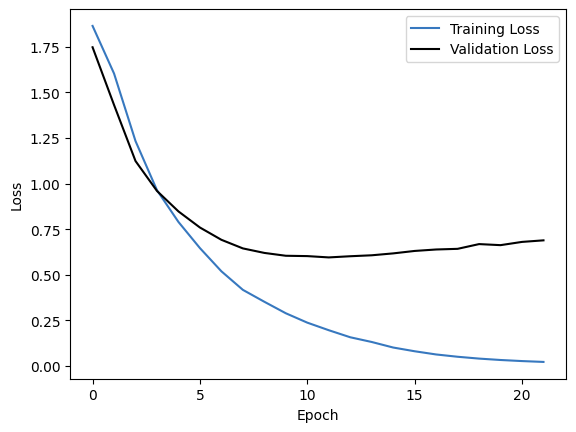

KeyError: 'accuracy'

In [94]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [95]:
# Personnel
pred = model.predict(["très bonnes compétences du chirurgien et de oncologue toujours bienveillants et à l'écoute"])
print("Probabilité : " + str(pred))

# Conditions hôtelières
pred = model.predict(["Le manque de chambres qui a fait que j'ai été en chambre double la première nuit avec une personne qui ne dormait pas et allumait la lumière et faisait sa vie comme si elle était seule."])
print("Probabilité : " + str(pred))

1/1 [==============================] - 0s 190ms/step
Probabilité : [[1.0061808e-05 9.9873787e-01 1.1330361e-03 1.0947762e-04 2.2348604e-06
  7.2808953e-06 6.4503190e-08]]
1/1 [==============================] - 0s 21ms/step
Probabilité : [[1.6465376e-04 4.4220481e-02 4.6452403e-04 4.4743167e-05 1.4615977e-04
  9.5495528e-01 4.1304115e-06]]


4/4 [==============================] - 0s 6ms/step - loss: 0.6884 - auc: 0.9560
Mean AUC score: [0.6884312033653259, 0.955983579158783]
4/4 [==============================] - 0s 6ms/step - loss: 0.6884 - auc: 0.9560


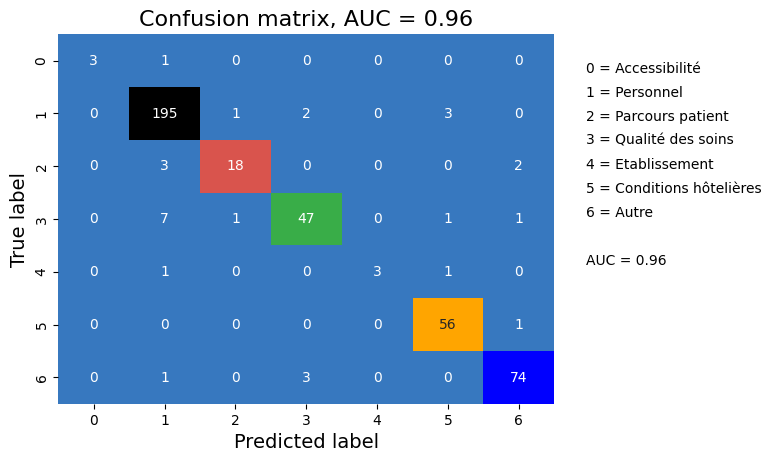

In [102]:
X = np.array(df['Verbatim'])
Y = np.array(df["Catégories Verbatims"])

legend1 = "0 = Accessibilité"
legend2 = "1 = Personnel"
legend3 = "2 = Parcours patient"
legend4 = "3 = Qualité des soins"
legend5 = "4 = Etablissement"
legend6 = "5 = Conditions hôtelières"
legend7 = "6 = Autre"
legend8 = "AUC = 0.96"

custom_palette = [sns.xkcd_rgb["windows blue"], sns.xkcd_rgb["pale red"], sns.xkcd_rgb["medium green"], "orange", "blue","yellow", "purple", "deeppink", "brown", "teal", "black"] 
sns.set_palette(custom_palette)

results = []
y_preds=model.predict(X)
for elm in y_preds:
    results.append(np.argmax(elm))
y_preds = results
print('Mean AUC score:',model.evaluate(x_test, y_test))
loss, accuracy = model.evaluate(x_test, y_test)
    
ax = sns.heatmap(tf.math.confusion_matrix(labels=Y, predictions=y_preds),annot=True,cbar=False,fmt='d',cmap=custom_palette)
ax.set_ylabel('True label',fontsize=14)
ax.set_xlabel('Predicted label',fontsize=14)
ax.set_title('Confusion matrix, AUC = ' + str(round(accuracy,2)),fontsize=16);
plt.gcf().text(0.95,0.8, legend1)
plt.gcf().text(0.95,0.75, legend2)
plt.gcf().text(0.95,0.7, legend3)
plt.gcf().text(0.95,0.65, legend4)
plt.gcf().text(0.95,0.6, legend5)
plt.gcf().text(0.95,0.55, legend6)
plt.gcf().text(0.95,0.5, legend7)
plt.gcf().text(0.95,0.4, legend8)

plt.savefig("Matrice de confusion multiclass_7 verbatims_mai2024", dpi=400, bbox_inches="tight")
plt.show()

## Entrainement du modèle catégorisation des verbatims en multiclass x39

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.set_visible_devices(physical_devices[1], 'GPU')
tf.config.experimental.set_memory_growth(physical_devices[1], True)

2024-06-06 10:54:27.597064: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-06 10:54:27.597242: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-06 10:54:27.617741: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
df = pd.read_excel('1-Extrait_Verbatim_Enq_Satisfaction_Patients HC 2023(1-1245)_mai2024_multiclass_select.xlsx')
df = df.fillna('')

In [26]:
df

,ID,Verbatim,Eloge / Suggestion d'amélioration / Neutre,Classement thématique,Service d'hospitalisation,Date de réception du questionnaire,Catégories Verbatims,"Disponibilité, réactivité, efficacité",Écoute et attention,"Compétences, sérieux et professionnalisme","Informations, explications et conseils",Qualités humaines,Accueil et admission,Qualité des soins,Douleur,Prise en charge globale,Chambre (confort / chambre individuelle),Bruit/calme,Alimentation,Autre
0,1,De la bienveillance de tout le personnel de to...,Eloge,Personnel - Qualités humaines;Personnel - Reme...,1ER-Chirurgieconventionnelle,2022-10-13,4,0,0,0,0,1,0,0,0,0,0,0,0,0
1,2,"disponibilité du personnel, toujours à l'écoute",Eloge,"Personnel - Disponibilité, réactivité, efficac...",1ER-Chirurgieconventionnelle,2022-10-13,0,1,1,0,0,0,0,0,0,0,0,0,0,0
2,3,l'ambiance et la prise en charge sont toujours...,Eloge,Qualité des soins - Prise en charge globale,4EME-HDSSoinsdesupport,2022-10-14,6,0,0,0,0,0,0,1,0,1,0,0,0,0
3,4,la qualite du personnel,Eloge,"Personnel - Compétences, sérieux et profession...",1ER-Chirurgieconventionnelle,2022-10-14,2,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,,Eloge,,4EME-HDSOncologiedesemaine,2022-10-14,12,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,421,Rien du tout,Neutre,,4EME-HDSOncologiedesemaine,2023-09-29,12,0,0,0,0,0,0,0,0,0,0,0,0,1
421,422,Pas assez de chambre individuelle,SA,Conditions hôtelières - Chambre (confort / cha...,4EME-HDSOncologiedesemaine,2023-09-29,9,0,0,0,0,0,0,0,0,0,1,0,0,0
422,423,L?accessibilité au centre due aux travaux du n...,SA,Accessibilité - Accès handicap / physique,1ER-Chirurgieconventionnelle,2023-09-30,12,0,0,0,0,0,0,0,0,0,0,0,0,0
423,424,Rien,Neutre,,4EME-HDSSoinsdesupport,2023-10-01,12,0,0,0,0,0,0,0,0,0,0,0,0,1


In [4]:
X_np   = np.array(df['Verbatim'])
Y = np.array(df["Catégories Verbatims"])

In [5]:
np.unique(Y)

array([ 0,  1,  2,  3,  4,  5,  6,  9, 10, 11, 12])

In [6]:
Y[Y==9]=7
Y[Y==10]=8
Y[Y==11]=9
Y[Y==12]=10

In [7]:
df["Catégories Verbatims"].value_counts()

12    99
1     67
6     66
0     38
4     35
2     34
9     30
11    24
3     17
5     10
10     5
Name: Catégories Verbatims, dtype: int64

In [8]:
x_train, x_test, y_train, y_test = train_test_split(X_np, 
                                                    Y, 
                                                    test_size=0.3, 
                                                    stratify=Y, 
                                                    random_state=7)

In [9]:
#pour l'utilisation de softmax:
y_train=keras.utils.to_categorical(y_train, num_classes=11, dtype=y_train.dtype)#'float32'
y_test=keras.utils.to_categorical(y_test, num_classes=11, dtype=y_train.dtype)#'float32'

In [44]:
y_train[0:10]

array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]])

In [45]:
x_train[0:10]

array(["le manque d'informations sur les médicaments spécifiques sur des cancers par les infirmières",
       'Tout', 'Peut-être le manque de chambre particulière',
       'rien tout été bien', 'Confiance et sécurité',
       'Établissement parfait prise en charge exceptionnelle étant ancienne infirmière je suis plus que satisfaite',
       'Rien',
       'D?être en chambre individuelle  La bienveillance générale des aide-soignants et des IDE Une salle de bain fonctionnelle et individuelle  Une chambre calme',
       'la nourriture', 'Rien à dire excellente'], dtype=object)

In [12]:
model = tf.keras.models.Sequential()

model.add(hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4', 
                        input_shape=[], 
                        dtype=tf.string, 
                        trainable=True))

model.add(tf.keras.layers.Dense(2048, activation='relu'))

model.add(tf.keras.layers.Dense(1024, activation='relu'))

model.add(tf.keras.layers.Dense(512, activation='relu'))

model.add(tf.keras.layers.Dense(11, activation='softmax'))

model.summary()

model.compile(optimizer=Adam(learning_rate=1e-4), 
              loss='categorical_crossentropy', 
              metrics=['AUC'])

earlystop = EarlyStopping(monitor='val_loss', patience=10)
#filepath = "./save_model/modelepochs:{epoch:03d}.hdf5"
#checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min', period=1) #mode was 'auto' #monitor was loss
#path = "./save_logs/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=path,histogram_freq=1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 512)               256797824 
                                                                 
 dense_4 (Dense)             (None, 2048)              1050624   
                                                                 
 dense_5 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_6 (Dense)             (None, 512)               524800    
                                                                 
 dense_7 (Dense)             (None, 11)                5643      
                                                                 
Total params: 260477067 (993.64 MB)
Trainable params: 260477067 (993.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
history=model.fit(x_train, y_train, epochs=1000, validation_data=(x_test, y_test), callbacks=[earlystop])

Epoch 1/1000


2024-06-06 10:55:05.358602: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


10/10 [==============================] - 6s 92ms/step - loss: 2.3588 - auc: 0.7074 - val_loss: 2.2904 - val_auc: 0.7761
Epoch 2/1000
10/10 [==============================] - 1s 62ms/step - loss: 2.2266 - auc: 0.8175 - val_loss: 2.1240 - val_auc: 0.7993
Epoch 3/1000
10/10 [==============================] - 1s 62ms/step - loss: 2.0357 - auc: 0.8311 - val_loss: 1.8894 - val_auc: 0.8247
Epoch 4/1000
10/10 [==============================] - 1s 63ms/step - loss: 1.8093 - auc: 0.8445 - val_loss: 1.6906 - val_auc: 0.8431
Epoch 5/1000
10/10 [==============================] - 1s 63ms/step - loss: 1.6006 - auc: 0.8791 - val_loss: 1.5251 - val_auc: 0.8787
Epoch 6/1000
10/10 [==============================] - 1s 62ms/step - loss: 1.4107 - auc: 0.9143 - val_loss: 1.3909 - val_auc: 0.9066
Epoch 7/1000
10/10 [==============================] - 1s 62ms/step - loss: 1.2118 - auc: 0.9423 - val_loss: 1.2675 - val_auc: 0.9209
Epoch 8/1000
10/10 [==============================] - 1s 63ms/step - loss: 1.0292 

In [15]:
dump(model, 'Best_model_multi_11_class_mai2024_06062024.joblib')

['Best_model_multi_11_class_mai2024_06062024.joblib']

In [258]:
model = load('Best_model_multi_11_class_mai2024_06062024.joblib')

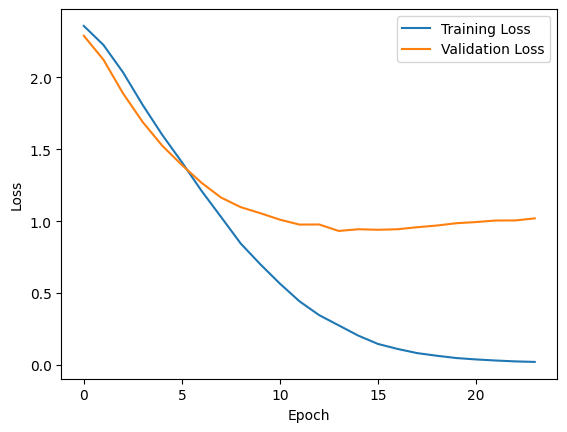

KeyError: 'accuracy'

In [16]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [17]:
# Personnel
pred = model.predict(["très bonnes compétences du chirurgien et de oncologue toujours bienveillants et à l'écoute"])
print("Probabilité : " + str(pred))

# Conditions hôtelières
pred = model.predict(["Le manque de chambres qui a fait que j'ai été en chambre double la première nuit avec une personne qui ne dormait pas et allumait la lumière et faisait sa vie comme si elle était seule."])
print("Probabilité : " + str(pred))

1/1 [==============================] - 0s 207ms/step
Probabilité : [[4.3703032e-01 3.4705928e-01 1.9386750e-01 8.0726913e-04 1.3581922e-02
  6.9437874e-03 1.9583500e-04 1.4056711e-05 3.9575511e-04 9.1856411e-05
  1.2464868e-05]]
1/1 [==============================] - 0s 20ms/step
Probabilité : [[3.1293563e-05 3.2551654e-06 7.1061157e-05 3.7253471e-03 3.7697486e-05
  7.5075797e-05 1.9972300e-05 9.9545068e-01 4.5183350e-04 7.0880647e-05
  6.3052408e-05]]


In [ ]:
rray([ 0,  1,  2,  3,  4,  5,  6,  9, 10, 11, 12])

4/4 [==============================] - 0s 6ms/step - loss: 1.0194 - auc: 0.9472
Mean AUC score: [1.0193564891815186, 0.9472381472587585]
4/4 [==============================] - 0s 6ms/step - loss: 1.0194 - auc: 0.9472


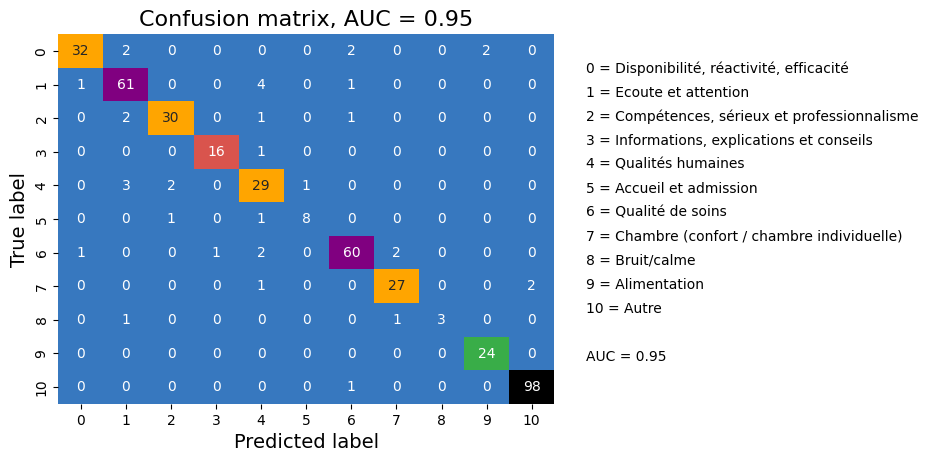

In [19]:
X = X_np
Y = Y

legend1 = "0 = Disponibilité, réactivité, efficacité"
legend2 = "1 = Ecoute et attention"
legend3 = "2 = Compétences, sérieux et professionnalisme"
legend4 = "3 = Informations, explications et conseils"
legend5 = "4 = Qualités humaines"
legend6 = "5 = Accueil et admission"
legend7 = "6 = Qualité de soins"
legend8 = "7 = Chambre (confort / chambre individuelle)"
legend9 = "8 = Bruit/calme"
legend10 = "9 = Alimentation"
legend11 = "10 = Autre"

legend12 = "AUC = 0.95"

custom_palette = [sns.xkcd_rgb["windows blue"], sns.xkcd_rgb["pale red"], sns.xkcd_rgb["medium green"], "orange", "blue","yellow", "purple", "deeppink", "brown", "teal", "black"] 
sns.set_palette(custom_palette)

results = []
y_preds=model.predict(X)
for elm in y_preds:
    results.append(np.argmax(elm))
y_preds = results
print('Mean AUC score:',model.evaluate(x_test, y_test))
loss, accuracy = model.evaluate(x_test, y_test)
    
ax = sns.heatmap(tf.math.confusion_matrix(labels=Y, predictions=y_preds),annot=True,cbar=False,fmt='d',cmap=custom_palette)
ax.set_ylabel('True label',fontsize=14)
ax.set_xlabel('Predicted label',fontsize=14)
ax.set_title('Confusion matrix, AUC = ' + str(round(accuracy,2)),fontsize=16);
plt.gcf().text(0.95,0.8, legend1)
plt.gcf().text(0.95,0.75, legend2)
plt.gcf().text(0.95,0.7, legend3)
plt.gcf().text(0.95,0.65, legend4)
plt.gcf().text(0.95,0.6, legend5)
plt.gcf().text(0.95,0.55, legend6)
plt.gcf().text(0.95,0.5, legend7)
plt.gcf().text(0.95,0.45, legend8)
plt.gcf().text(0.95,0.4, legend9)
plt.gcf().text(0.95,0.35, legend10)
plt.gcf().text(0.95,0.3, legend11)
plt.gcf().text(0.95,0.2, legend12)
plt.savefig("Matrice de confusion multiclass_11 verbatims_mai2024", dpi=400, bbox_inches="tight")
plt.show()